In [1]:
import os
import pandas as pd
import numpy as np
import tacoreader
import ee
import rasterio

folder_path = '../src'
os.chdir(folder_path)
from dataset_utils.download_data import download_cloudsen12plus
from dataset_utils.evaluation import compute_metrics, visualize_results, generate_mask

In [2]:
# Baixar os dados (caso ainda não estejam baixados)
parts = download_cloudsen12plus(local_dir="../data/dados", type="L1C")
print("Arquivos baixados:", parts)

Arquivos baixados: ['..\\data\\dados\\cloudsen12-l1c.0000.part.taco', '..\\data\\dados\\cloudsen12-l1c.0004.part.taco']


In [3]:
# Carregar o dataset
ds = tacoreader.load(parts)
print("Número total de amostras:", len(ds))

Número total de amostras: 16135


In [4]:
df = pd.DataFrame(ds)
print("Colunas do DataFrame:", df.columns)

Colunas do DataFrame: Index(['internal:subfile', 'tortilla:id', 'tortilla:file_format',
       'tortilla:data_split', 'tortilla:offset', 'tortilla:length', 'stac:crs',
       'stac:geotransform', 'stac:raster_shape', 'stac:time_start',
       'stac:time_end', 'stac:centroid', 'rai:ele', 'rai:cisi', 'rai:gdp',
       'rai:hdi', 'rai:gmi', 'rai:pop', 'rai:admin0', 'rai:admin1',
       'rai:admin2', 'roi_id', 'old_roi_id', 'equi_id', 'equi_zone',
       'label_type', 's2_id', 'real_proj_shape', 's2_mean_solar_azimuth_angle',
       's2_mean_solar_zenith_angle', 'thick_percentage', 'thin_percentage',
       'cloud_shadow_percentage', 'clear_percentage'],
      dtype='object')


In [5]:
test_tdf = df[
    (df["tortilla:data_split"] == "test") &
    (df["label_type"] == "high") &
    (ds["real_proj_shape"] == 509)
]
len(test_tdf)

975

In [6]:
ds = tacoreader.load(parts)
sample = ds.read(10)
sample

,internal:subfile,tortilla:id,tortilla:file_format,tortilla:data_split,tortilla:offset,tortilla:length,stac:crs,stac:geotransform,stac:raster_shape,stac:time_start,stac:time_end,stac:centroid
0,"/vsisubfile/7235135_1359647,..\data\dados\clou...",s2l1c,GTiff,None,7235135,1359647,EPSG:32719,"[502160.0, 10.0, 0.0, 7567380.0, 0.0, -10.0]","[512, 512]",1.549637e+09,1.549637e+09,POINT (-68.954266 -22.021252)
1,"/vsisubfile/8594782_7153,..\data\dados\cloudse...",target,GTiff,None,8594782,7153,EPSG:32719,"[502160.0, 10.0, 0.0, 7567380.0, 0.0, -10.0]","[512, 512]",1.549637e+09,1.549637e+09,POINT (-68.954266 -22.021252)


Métricas calculadas:
IoU_Clear: 0.416
IoU_Cloud: 0.824
F1: 0.746
Recall: 0.734
Precision: 0.760
Valores únicos na ground truth: [0 1 3]


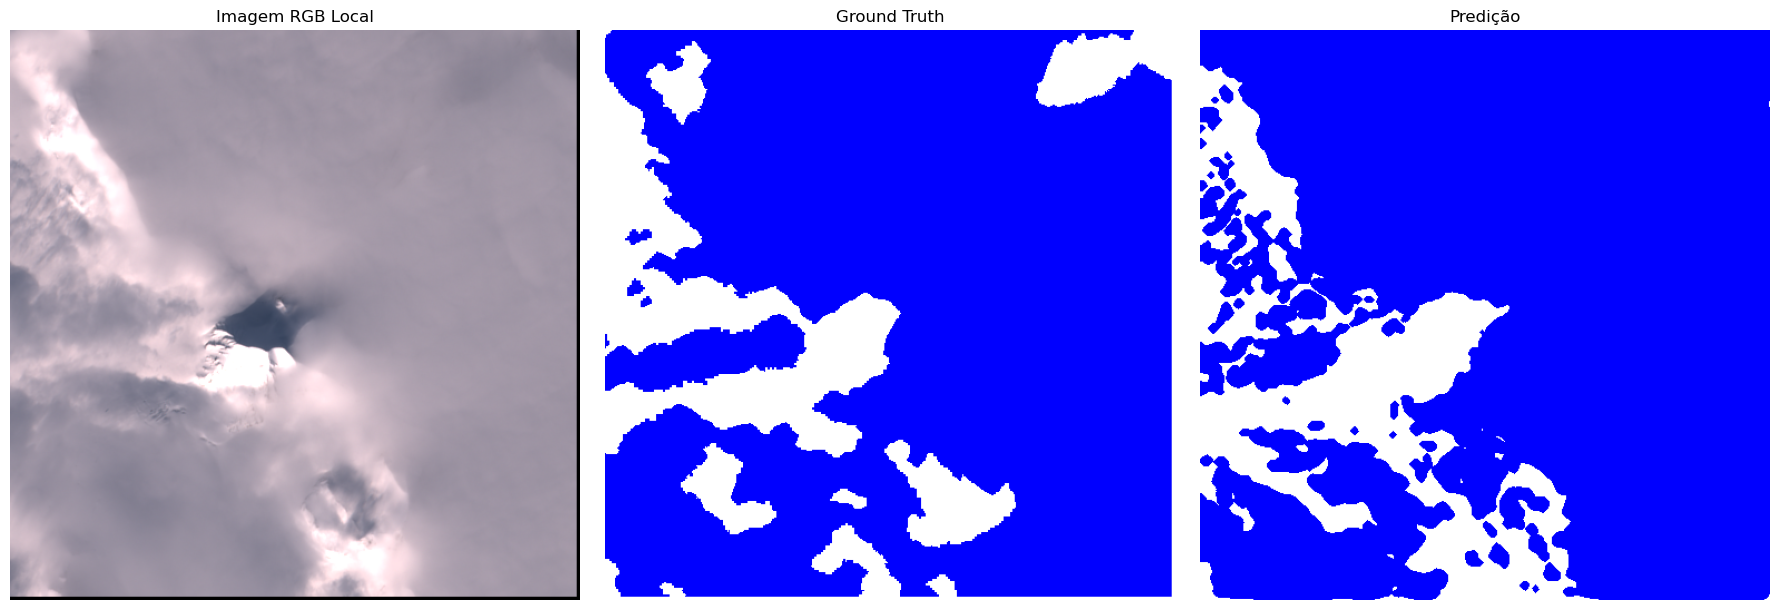

In [7]:
# Carrega a amostra (cada linha é uma Series do pandas)
ds = tacoreader.load(parts)
index = test_tdf.index[180]
sample = ds.read(index)

# Gerar a máscara predita usando o algoritmo
pred_mask = generate_mask(sample)

# Calcular as métricas (passando None para gt_mask_unused, já que a ground truth é lida dentro da função)
metrics = compute_metrics(sample, None, pred_mask)
print("Métricas calculadas:")
for k, v in metrics.items():
    print(f"{k}: {v:.3f}")

with rasterio.open(sample.read(1)) as src_mask:
    ground_truth = src_mask.read(1)
print("Valores únicos na ground truth:", np.unique(ground_truth))
# Remapeia a ground truth conforme definido (1: Thick Cloud, os demais para Clear)
gt_mask = np.where(ground_truth == 1, 1, 0)

# Visualizar a imagem RGB, a ground truth e a predição
visualize_results(sample, gt_mask, pred_mask)

In [8]:
# Inicializa um dicionário para acumular as métricas
all_metrics = {
    "IoU_Clear": [],
    "IoU_Cloud": [],
    "F1": [],
    "Recall": [],
    "Precision": []
}

# Itera por todos os índices de test_tdf
for idx in test_tdf.index:
    sample = ds.read(idx)
    pred_mask = generate_mask(sample)
    metrics = compute_metrics(sample, None, pred_mask)
    
    # Armazena cada métrica
    for k, v in metrics.items():
        all_metrics[k].append(v)

# Calcula a média para cada métrica
mean_metrics = {k: sum(v) / len(v) for k, v in all_metrics.items()}

# Exibe as médias
print("Média das métricas:")
for k, v in mean_metrics.items():
    print(f"{k}: {v:.3f}")

Média das métricas:
IoU_Clear: 0.628
IoU_Cloud: 0.453
F1: 0.654
Recall: 0.698
Precision: 0.774
